# Installing Librarys

In [1]:
!pip install transformers
!pip install accelerate
!pip install datasets
!pip install bertviz
!pip install umap-learn


# Importing Libraries and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline



In [3]:
df = pd.read_csv('twitter_multi_class_sentiment.csv')

In [4]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [5]:
# HOw many data we have
len(df)

16000

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [7]:
#Check missing data
df.isnull().sum()

,0
text,0
label,0
label_name,0


In [8]:
# Reduce the data for speedup since this notebook just for exploring
df = df.sample(frac=0.1, random_state=42)

In [9]:
# How many labels do we have
df['label_name'].unique(),len(df['label_name'].unique())

(array(['sadness', 'joy', 'fear', 'love', 'anger', 'surprise'],
       dtype=object),
 6)

In [10]:
number_of_labels = len(df['label_name'].unique())

In [11]:
df['label_name'].value_counts()

,count
label_name,
joy,503
sadness,494
anger,217
fear,174
love,159
surprise,53


We have an imbalance in the data, but it won't be that much of a problem.


# EDA

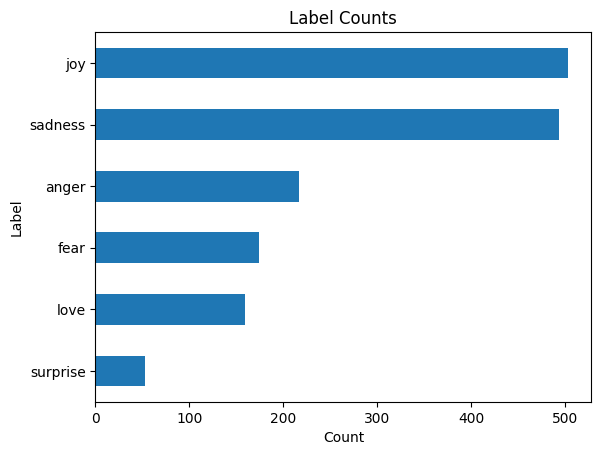

In [12]:
# Vicualise our labels
labels_counts = df['label_name'].value_counts(ascending=True)
labels_counts.plot(kind='barh', title='Label Counts')
plt.ylabel('Label')
plt.xlabel('Count')
plt.show()

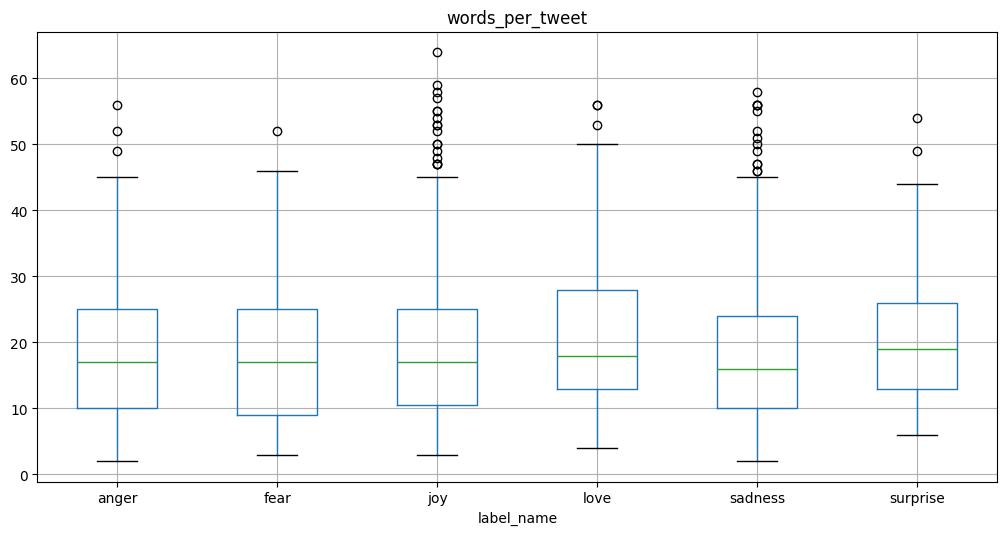

In [13]:
# Visualize our number of words in our data using boxplot
df['words_per_tweet'] = df['text'].apply(lambda x: len(x.split()))
df.boxplot('words_per_tweet',by='label_name',figsize=(12,6))
plt.suptitle('')
plt.show()

- **Love**: Has a higher median.
- **Sadness**: Has more outliers due to having more data and the lowest median.


In [14]:
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
text = 'I love machine learning! Tokenization is a fundamental step in NLP.'
encodded_text = tokenizer(text)
print(encodded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 1037, 8050, 3357, 1999, 17953, 2361, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


#Prepare Train Text sets

In [16]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df,test_size=0.3,random_state=42,stratify=df['label_name'])
test, validaion = train_test_split(test,test_size=1/3,random_state=42,stratify=test['label_name'])

train.shape,test.shape,validaion.shape

((1120, 4), (320, 4), (160, 4))

In [17]:
# This code converts Pandas DataFrames into a Hugging Face DatasetDict for efficient use with transformers.

from datasets import Dataset, DatasetDict
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Define the tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True)

# Convert your Pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)
validation_dataset = Dataset.from_pandas(validaion)

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)

# Create a DatasetDict to organize the datasets for training, testing, and validation
dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

# Output the created DatasetDict object
dataset


Map:   0%|          | 0/1120 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1120
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 160
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 320
    })
})

#Model Building

In [18]:
from transformers import AutoModel
import torch
model = AutoModel.from_pretrained(model_ckpt)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [19]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [20]:
# This code initializes a sequence classification model with a custom configuration for label mapping.

from transformers import AutoModelForSequenceClassification, AutoConfig

# Extract the unique labels from the dataset
labels = df['label_name'].unique().tolist()

# Define the total number of labels for classification
num_labels = number_of_labels

# Check if a GPU (CUDA) is available; otherwise, default to the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a custom configuration for the model
config = AutoConfig.from_pretrained(
    model_ckpt,  # Pre-trained model checkpoint to load the configuration from
    num_labels=num_labels,  # Number of labels for classification
    label2id={l: i for i, l in enumerate(labels)},  # Map each label to an ID
    id2label={i: l for i, l in enumerate(labels)}   # Map each ID back to its corresponding label
)

# Load the pre-trained sequence classification model with the custom configuration
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,  # Pre-trained model checkpoint to load the model from
    config=config  # Custom configuration for label mapping
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
device

device(type='cpu')

In [22]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "fear",
    "3": "love",
    "4": "anger",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 4,
    "fear": 2,
    "joy": 1,
    "love": 3,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [23]:
# This code sets up training arguments for fine-tuning a transformer model using Hugging Face's Trainer.

from transformers import TrainingArguments

# Define the batch size for both training and evaluation
batch_size = 64

# Metric used for evaluation (e.g., F1 score)
metric_name = 'f1'

# Directory where the training outputs (model checkpoints, logs, etc.) will be saved
train_dir = 'bert_base_dir'

# Initialize training arguments for the Hugging Face Trainer
args = TrainingArguments(
    train_dir,  # Directory to save model checkpoints and logs
    overwrite_output_dir=True,  # Overwrite the output directory if it already exists
    num_train_epochs=2,  # Number of training epochs
    learning_rate=2e-5,  # Learning rate for the optimizer
    per_device_train_batch_size=batch_size,  # Batch size for training on each device (e.g., GPU)
    per_device_eval_batch_size=batch_size,  # Batch size for evaluation on each device
    weight_decay=0.01,  # Weight decay to apply for regularization
    evaluation_strategy='epoch',  # Perform evaluation at the end of each epoch
    save_strategy='epoch',  # Save model checkpoints at the end of each epoch
    #run_name="my_experiment_name",  # Unique name for the experiment in W&B
    run_name='wb_holder',  # Set a unique run name to avoid the warning
    report_to=None  # Disable W&B logging
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00


In [25]:
# This code sets up metric evaluation functions for a model and defines a method to compute evaluation metrics.

import evaluate  # Hugging Face's evaluate library for metric calculations
import numpy as np  # NumPy library for numerical operations

# Load the accuracy metric
accuracy = evaluate.load('accuracy')

# Load the F1 score metric
f1 = evaluate.load('f1')

# Load the recall metric
recall = evaluate.load('recall')

# Function to compute evaluation metrics
def compute_metrics_evaluate(eval_pred):
    """
    Computes evaluation metrics for predictions made by the model.

    Args:
        eval_pred: A tuple containing model predictions and the true labels.

    Returns:
        A dictionary with computed metrics (e.g., accuracy).
    """
    # Convert model logits to predicted class indices
    predictions = np.argmax(eval_pred.predictions, axis=1)

    # Calculate and return the accuracy score by comparing predictions and true labels
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)


In [26]:
# This code defines a function to compute F1 and accuracy metrics for model predictions using scikit-learn.

from sklearn.metrics import f1_score, accuracy_score  # Import metrics for F1 score and accuracy calculations

# Function to compute evaluation metrics
def compute_metrics(pred):
    """
    Computes F1 score and accuracy for model predictions.

    Args:
        pred: An object containing model predictions and true labels.
              - pred.label_ids: The true labels.
              - pred.predictions: The model's predicted logits.

    Returns:
        A dictionary containing the F1 score and accuracy.
    """
    # Extract the true labels
    labels = pred.label_ids

    # Convert logits to predicted class indices
    preds = pred.predictions.argmax(-1)

    # Calculate the weighted F1 score
    f1 = f1_score(labels, preds, average="weighted")

    # Calculate the accuracy score
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {"f1": f1, "accuracy": acc}


# Build model and trainer

In [27]:
# This code initializes a Hugging Face Trainer to handle model training, evaluation, and metric computation.

from transformers import Trainer  # Import Trainer class for managing training and evaluation

# Create a Trainer instance to manage training and evaluation
trainer = Trainer(
    model=model,  # The pre-trained model to fine-tune
    args=args,  # Training arguments, such as batch size, learning rate, and number of epochs
    compute_metrics=compute_metrics_evaluate,  # Function to compute evaluation metrics (e.g., accuracy, F1)
    train_dataset=dataset['train'],  # Training dataset
    eval_dataset=dataset['validation'],  # Validation dataset for evaluation during training
    tokenizer=tokenizer  # Tokenizer used for data preprocessing
)


<ipython-input-27-df9085edeeaa>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [28]:
import os
os.environ["WANDB_MODE"] = "disabled"


In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.576289,0.400000
2,No log,1.526319,0.431250


TrainOutput(global_step=36, training_loss=1.6256884468926325, metrics={'train_runtime': 1663.9472, 'train_samples_per_second': 1.346, 'train_steps_per_second': 0.022, 'total_flos': 75976045770240.0, 'train_loss': 1.6256884468926325, 'epoch': 2.0})

# Ofcourse this accurcy is very poor but remember we only using 10% of the data

In [30]:
pred_outputs = trainer.predict(dataset['test'])

In [32]:
pred_outputs.metrics

{'test_loss': 1.531111478805542,
 'test_accuracy': 0.45,
 'test_runtime': 67.8795,
 'test_samples_per_second': 4.714,
 'test_steps_per_second': 0.074}

In [44]:
# Import the classification_report function from scikit-learn
from sklearn.metrics import classification_report

# Convert model's raw prediction outputs (logits/probabilities) into predicted class labels
# `np.argmax` selects the index of the maximum value along the specified axis (axis=1 for rows)
y_pred = np.argmax(pred_outputs.predictions, axis=1)

# Extract the true class labels from the test dataset
y_true = dataset['test']['label']

# Generate and print a detailed classification report, including precision, recall, F1-score, and support
# `y_true` are the true labels, and `y_pred` are the model's predicted labels
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.40      0.81      0.54        99
           1       0.52      0.64      0.58       100
           2       0.00      0.00      0.00        32
           3       0.00      0.00      0.00        43
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00        11

    accuracy                           0.45       320
   macro avg       0.15      0.24      0.19       320
weighted avg       0.29      0.45      0.35       320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


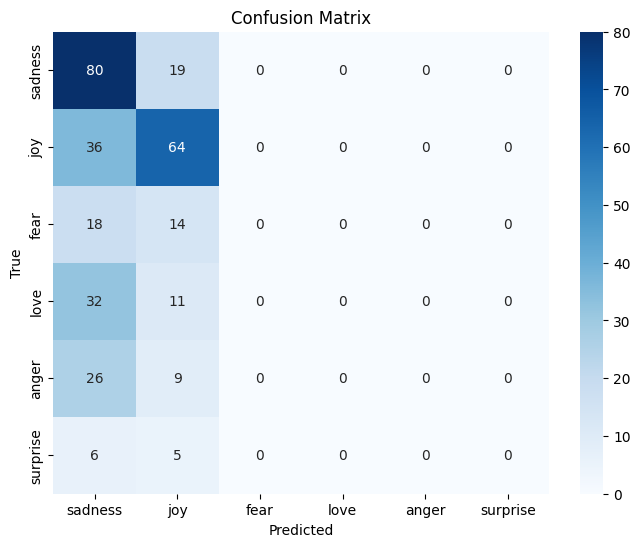

In [47]:
# plot confutsion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Model Performance Issues**

The model performed poorly due to the following reasons:  
1. **Imbalanced Data**: The dataset used for training and evaluation was not balanced, leading to biased predictions.  
2. **Limited Data**: Only a small subset of the data was used, constrained by computational limits on Google Colab.


In [46]:
df.label_name.value_counts()

,count
label_name,
joy,503
sadness,494
anger,217
fear,174
love,159
surprise,53


#Build predition function and save it for later purpose


In [58]:
def predict_text_sentiment(text, model, tokenizer, device, labels):
    """
    Predicts the sentiment of a given text using a pre-trained model.

    Parameters:
    - text (str): The input text for sentiment analysis.
    - model (torch.nn.Module): The pre-trained model for text classification.
    - tokenizer (transformers.PreTrainedTokenizer): The tokenizer for text preprocessing.
    - device (torch.device): The device (CPU or GPU) where the model and data are processed.
    - labels (list): A list of label names corresponding to the model's output classes.

    Returns:
    - tuple: The predicted class index and the corresponding label name.
    """

    # Tokenize the text and convert it into tensor format for PyTorch
    # The `return_tensors='pt'` converts the output to a PyTorch tensor
    # The `.to(device)` ensures the tensor is moved to the appropriate device (CPU or GPU)
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    # Perform a forward pass through the model without computing gradients
    # `torch.no_grad()` disables gradient tracking for faster inference
    with torch.no_grad():
        outputs = model(**input_encoded)  # Get the model's output for the encoded input

    # Extract the logits (raw predictions) from the model's output
    logits = outputs.logits

    # Compute the predicted class index
    predict = np.argmax(logits, axis=1)

    # Return the predicted class index and the corresponding label name
    return predict, labels[predict[0]]


In [59]:
text='I love machine learning! Tokenization is a fundamental step in NLP.'
predict_text_sentiment(text,model,tokenizer,device,labels)

(tensor([1]), 'joy')

In [60]:
# Save the model
model.save_pretrained('model')